<a href="https://colab.research.google.com/github/salinator-hub/Dspy-/blob/main/NutritionalAdvice_Recommendation_petsTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Serve the model using vLLM

In [1]:
!pip install dspy-ai vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [63]:
# Run server in foreground
# !python -m vllm.entrypoints.openai.api_server --model TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ --quantization awq

# Run server in the background
!nohup python -m vllm.entrypoints.openai.api_server --model TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ --quantization awq > server.log 2>&1 &
# stdout is redirected to a file `server.log` using `> server.log`.
# We use a quantized model prepared using AWQ quantization

In [69]:
# Run this cell again and again to monitor the status of the server.
# The server can take a few mintues to start.
# Once the server has started, you will see logs such as this:
# INFO 02-10 07:16:43 llm_engine.py:877] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%
!tail server.log

INFO 02-20 21:23:23 weight_utils.py:163] Using model weights format ['*.safetensors']
INFO 02-20 21:23:52 llm_engine.py:337] # GPU blocks: 2120, # CPU blocks: 2048
INFO 02-20 21:23:55 model_runner.py:666] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 02-20 21:23:55 model_runner.py:670] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 02-20 21:24:10 model_runner.py:738] Graph capturing finished in 15 secs.
WARNING 02-20 21:24:10 serving_chat.py:264] No chat template provided. Chat API will not work.
INFO:     Started server process [15367]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn runn

In [70]:
# Once the server is up and running, this should work
!curl http://localhost:8000/v1/models

{"object":"list","data":[{"id":"TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ","object":"model","created":1708464266,"owned_by":"vllm","root":"TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ","parent":null,"permission":[{"id":"modelperm-91bd16b0ff4d4893b03eee47a59b8565","object":"model_permission","created":1708464266,"allow_create_engine":false,"allow_sampling":true,"allow_logprobs":true,"allow_search_indices":false,"allow_view":true,"allow_fine_tuning":false,"organization":"*","group":null,"is_blocking":false}]}]}

# DSPy: 𝗗eclarative 𝗦elf-improving Language 𝗣rograms

In [13]:
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BayesianSignatureOptimizer, BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune


In [12]:
lm = dspy.HFClientVLLM(model="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", port=8000, url="http://localhost")

dspy.settings.configure(lm=lm)

colbertv2 = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')

# # NOTE: After you finish this notebook, you can use GPT-3.5 like this if you like.
# turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct')
# # In that case, make sure to configure lm=turbo below if you choose to do that.

dspy.settings.configure(rm=colbertv2)

In [14]:
class NutritionalAdvice(dspy.Signature):
    """Provide nutritional advice and dietary recommendations for pets and animals."""

    query = dspy.InputField(desc="Query from pet owners or farmers regarding nutritional advice")
    recommendation = dspy.OutputField(desc="Nutritional advice and dietary recommendations")


# Example usage:
query = "My dog has allergies and digestive issues. What dietary adjustments can I make to alleviate his symptoms?"
recommendation = "Transition to a hypoallergenic dog food formula with limited ingredients and novel protein sources. Avoid common allergens such as wheat, corn, and soy. Monitor for improvements in digestion and consult with a veterinarian for additional guidance."

nutrition_advice = dspy.ChainOfThought(NutritionalAdvice)
result = nutrition_advice(query=query)
print(result.recommendation)


To alleviate your dog's allergies and digestive issues, consider the following dietary adjustments:

1. Hypoallergenic diet: Switch to a hypoallergenic dog food that is specifically formulated for dogs with allergies. These foods typically contain novel proteins and carbohydrates that your dog has not been exposed to before, reducing the likelihood of an allergic reaction.

2. Limited ingredient diet: Choose a limited ingredient diet that contains


In [ ]:
# Import the required classes and functions
import dspy

# Define the NutritionalAdvice class
class NutritionalAdvice(dspy.Signature):
    """Provide nutritional advice and dietary recommendations for pets and animals."""

    query = dspy.InputField(desc="Query from pet owners or farmers regarding nutritional advice")
    recommendation = dspy.OutputField(desc="Nutritional advice and dietary recommendations")


# Example usage:
# Query from a pet owner about their cat's dietary needs
query_cat = "My cat has been gaining weight and seems lethargic. What dietary changes should I make to help her lose weight and regain energy?"
# Query from a farmer about their cow's nutritional requirements
query_cow = "My dairy cow's milk production has decreased, and she appears undernourished. What dietary adjustments can I make to improve her health and milk yield?"

# Instantiate the NutritionalAdvice module
nutrition_advice = dspy.Predict(NutritionalAdvice)

# Get nutritional advice and dietary recommendations for the cat
result_cat = nutrition_advice(query=query_cat)
print("For the cat:")
print("Query:", query_cat)
print("Recommendation:", result_cat.recommendation)

# Get nutritional advice and dietary recommendations for the cow
result_cow = nutrition_advice(query=query_cow)
print("\nFor the cow:")
print("Query:", query_cow)
print("Recommendation:", result_cow.recommendation)


For the cat:
Query: My cat has been gaining weight and seems lethargic. What dietary changes should I make to help her lose weight and regain energy?
Recommendation: To help your cat lose weight and regain energy, consider the following dietary changes:

1. Consult with your veterinarian: Before making any changes to your cat's diet, consult with your veterinarian to ensure that any weight gain is not due to an underlying health issue.

2. Feed a high-quality, balanced diet: Choose a high-quality, balanced cat food that is specifically formulated for weight management. Look for a food that is low in calories and high in protein, as this can help your cat feel full while consuming fewer calories.

3. Monitor portion sizes: Be sure to measure out your cat's food portions to ensure that you are not overfeeding.

For the cow:
Query: My dairy cow's milk production has decreased, and she appears undernourished. What dietary adjustments can I make to improve her health and milk yield?
Recomme

In [76]:
%%writefile NutritionalAdvice.py

#ALL THE IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune
from dspy.teleprompt import KNNFewShot
from dspy.predict.knn import KNN
import argparse
from dspy.teleprompt import BayesianSignatureOptimizer

#MODEL
model_name="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ"
lm = dspy.HFClientVLLM(model=model_name, port=8000, url="http://localhost")
dspy.settings.configure(lm=lm)

train = [
    ("My cow seems to be losing weight and producing less milk. What should I feed her to improve her condition?",
     "recommendation: Provide a balanced diet rich in green fodder, protein supplements, and minerals such as calcium and phosphorus. Monitor her body condition and consult with a veterinarian for further evaluation if needed."),

    ("My goat herd is showing signs of poor growth and low energy levels. How can I improve their health and productivity?",
     "recommendation: Offer a diet consisting of high-quality hay, grains, and protein-rich supplements to support growth and energy requirements. Ensure access to clean water and shelter from harsh weather conditions."),

    ("My chicken flock is experiencing a drop in egg production. What dietary changes can I make to boost their egg-laying performance?",
     "recommendation: Provide a balanced diet with layers pellets containing essential nutrients like calcium and protein. Supplement with calcium-rich foods such as oyster shells and ensure access to fresh water and clean nesting boxes."),

    ("My fish are showing signs of stress and poor growth in the pond. How can I improve their health and growth rate?",
     "recommendation: Optimize pond water quality by maintaining proper oxygen levels, pH balance, and temperature. Offer a balanced diet with high-quality fish feed containing essential nutrients. Monitor water parameters regularly and adjust feeding regimen accordingly."),

    ("My dog has allergies and digestive issues. What dietary adjustments can I make to alleviate his symptoms?",
     "recommendation: Transition to a hypoallergenic dog food formula with limited ingredients and novel protein sources. Avoid common allergens such as wheat, corn, and soy. Monitor for improvements in digestion and consult with a veterinarian for additional guidance."),

    ("My cat is overweight and inactive. How can I help her lose weight and stay healthy?",
     "recommendation: Implement portion control by measuring out daily food rations and feeding smaller, more frequent meals. Choose a weight management cat food formula with reduced calorie content. Encourage regular exercise through interactive play and environmental enrichment."),

    ("My horse is prone to colic and digestive issues. What dietary changes can I make to prevent these problems?",
     "recommendation: Provide a diet consisting of high-quality forage such as grass hay or pasture, supplemented with a low-starch, high-fiber concentrate feed. Offer plenty of clean water and implement a regular deworming and dental care schedule."),

    ("My sheep are grazing on poor-quality pasture and have rough coats. How can I improve their nutrition and coat condition?",
     "recommendation: Supplement grazing with high-quality hay or forage and provide access to mineral blocks containing essential trace minerals. Monitor for signs of nutritional deficiencies such as poor coat quality and consult with a veterinarian for dietary adjustments."),

    ("My poultry birds are exhibiting signs of vitamin deficiencies. What dietary supplements can I provide to address this?",
     "recommendation: Offer vitamin supplements in their water or feed, especially those containing vitamins A, D, and E, which are essential for poultry health and productivity. Ensure access to fresh greens and forage to support natural vitamin intake."),

    ("My aquarium fish are prone to swim bladder issues. What dietary changes can I make to prevent this?",
     "recommendation: Offer a varied diet consisting of high-quality fish flakes, pellets, and live or frozen foods. Avoid overfeeding and provide sinking foods for bottom-dwelling fish. Monitor fish behavior and adjust feeding regimen accordingly."),
]

# Development dataset
devset = [
    ("My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",
     "recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to aid in digestion. Monitor her teeth regularly and consult with a veterinarian for dental trimming if necessary."),

    ("My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?",
     "recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access to clean nesting boxes and stress-free environment."),

    ("My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?",
     "recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell condition regularly."),

    ("My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?",
     "recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management of high-risk feeds such as grains and legumes."),

    ("My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?",
     "recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as toys, foraging opportunities, and social interaction to reduce stress."),

    ("My aquaponics system is experiencing nutrient deficiencies. How can I adjust the fish feed to address this?",
     "recommendation: Evaluate the fish feed formulation to ensure it provides adequate nutrients for both fish and plants. Consider supplementing with organic fertilizers or nutrient additives to maintain optimal nutrient levels in the aquaponic system."),

    ("My pet snake is refusing to eat. How can I entice him to eat and ensure proper nutrition?",
     "recommendation: Offer appropriately sized prey items and try scenting with prey attractants such as fish oil or chicken broth. Ensure proper husbandry conditions such as temperature, humidity, and enclosure size to promote feeding response."),

    ("My backyard pond fish are experiencing fin rot and skin lesions. What dietary changes can I make to support their immune system?",
     "recommendation: Offer a balanced diet with immune-boosting ingredients such as garlic and vitamin supplements. Monitor water quality and implement regular water changes to reduce stress and disease risk."),

    ("My pet ferret is losing fur and seems lethargic. How can I improve his coat condition and energy levels?",
     "recommendation: Provide a balanced diet with high-quality ferret kibble and occasional treats such as cooked meats or eggs. Ensure plenty of opportunities for exercise and mental stimulation through interactive play and enrichment activities."),

    ("My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?",
     "recommendation: Offer a diet with lower protein content to reduce fish waste and nutrient input into the pond. Consider adding algae-eating fish species such as koi or grass carp to help naturally control algae levels."),
]


# Convert the dataset into DSPy Examples
train = [dspy.Example(query=query, recommendation=recommendation).with_inputs('query') for query, recommendation in train]
devset = [dspy.Example(query=query, recommendation=recommendation).with_inputs('query') for query, recommendation in devset]

# Print the lengths of trainset and devset
#print(len(train), len(devset))

# Access an example from trainset and devset
train_example = train[0]
dev_example = devset[0]
# print(train_example.query)



def should_be_correct(que, rec):
  check=dspy.ChainOfThought("query -> recommendation", n = 5)
  result=check(query=f"Is this {rec}; a correct recommendation for {que}. Return 0 for False and 1 for True.")
  if result.recommendation==0:
    return False
  else:
    return True
class NutritionalAdvice(dspy.Signature):
    """Provide nutritional advice and dietary recommendations for pets and animals."""

    query = dspy.InputField(desc="Query from pet owners or farmers regarding nutritional advice")
    recommendation = dspy.OutputField(desc="Nutritional advice and dietary recommendations")

class NutritionalAdvicePipelineAssertions(dspy.Module):
    def __init__(self, assert_on=True):
        super().__init__()
        self.assert_on = assert_on
        self.NutritionalAdvice_predicted = dspy.ChainOfThought(NutritionalAdvice)

    def forward(self, query, **kwargs):
        predicted_NutritionalAdvice = self.NutritionalAdvice_predicted(query=query)

        if self.assert_on:
            dspy.Suggest(
                should_be_correct(query, predicted_NutritionalAdvice),
                "NutritionalAdvice is correct.",
                target_module=NutritionalAdvice
            )

        return predicted_NutritionalAdvice


class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_query = dspy.InputField()
    assessment_recommendation = dspy.OutputField(desc="Only True or False")

def metric(gold, pred, trace=None):
    query, recommendation, emos = gold.query, gold.recommendation, pred.recommendation

    relevance = f"The predicted  recommendation{emos} are relevant to the context of the query {query}. The gold recommendation is {recommendation}"
    diversity = f"The predicted recommendation {emos} demonstrate a diverse range of recommendation for the query {query}. The gold recommendation is {recommendation}"
    correctness = f"The given recommendation {emos} will be effective for this query {query}. The gold recommendation is {recommendation}"
    informativeness = f"For this query {query}, the given recommendation {emos} are informative. The gold recommendation is {recommendation}"

    relevant = dspy.ChainOfThought(Assess)(assessed_text=query, assessment_query=relevance)
    diverse = dspy.ChainOfThought(Assess)(assessed_text=query, assessment_query=diversity)
    correct = dspy.ChainOfThought(Assess)(assessed_text=query, assessment_query=correctness)
    informative = dspy.ChainOfThought(Assess)(assessed_text=query, assessment_query=informativeness)

    relevance_score = 1 if relevant.assessment_recommendation == 'True' else 0
    diversity_score = 1 if diverse.assessment_recommendation == 'True' else 0
    correctness_score = 1 if correct.assessment_recommendation == 'True' else 0
    informativeness_score = 1 if informative.assessment_recommendation == 'True' else 0

    # Assign different weights to each measure
    relevance_weight = 0.25
    diversity_weight = 0.25
    correctness_weight = 0.25
    informativeness_weight = 0.25

    # Combine scores with weights
    weighted_score = (relevance_weight * relevance_score) + (diversity_weight * diversity_score) + \
                     (correctness_weight * correctness_score) + (informativeness_weight * informativeness_score)

    return max(0, weighted_score)


# Define your devset and kwargs here
# Replace placeholders with your actual development dataset and any additional keyword arguments you need for evaluation

kwargs = dict(display_progress=True, display_table=5)

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate( devset = devset, num_threads=1, display_progress=True, display_table=5)

# Define function to evaluate pipeline
def evaluate_pipeline(model_name, assertion=True, bayesian=True):
    NutritionalAdvice_predicted = NutritionalAdvicePipelineAssertions()

    # Compile the pipeline with specified configurations
    if assertion and bayesian:
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(NutritionalAdvice_predicted, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Optimized Pipeline"
    elif assertion and not bayesian:
        compiled_pipeline = NutritionalAdvice_predicted
        config_label = "Without Bayesian"
    elif not assertion and bayesian:
        without_assertion=NutritionalAdvicePipelineAssertions(assert_on=False)
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(without_assertion, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Without Assertion"
    else:
        without_assertion_and_bayesian=NutritionalAdvicePipelineAssertions(assert_on=False)
        compiled_pipeline = without_assertion_and_bayesian
        config_label = "No Assertion and No Bayesian"

    # Evaluate the compiled pipeline
    eval_score = evaluate_on_hotpotqa(compiled_pipeline, metric=metric)
    return eval_score, config_label


# Run the evaluation for each configuration
def run_ablation_study(model_name, disable_assertion=False, disable_bayesian=False):
    scores = []
    config_labels = []

    for assertion in [True, False]:
        if disable_assertion and not assertion:
            continue
        for bayesian in [True, False]:
            if disable_bayesian and not bayesian:
                continue
            eval_score, config_label = evaluate_pipeline(model_name, assertion=assertion, bayesian=bayesian)
            scores.append(eval_score)
            config_labels.append(config_label)

    return scores, config_labels

def use_pipeline_as_user(model_name, query):
    NutritionalAdvice_predicted = NutritionalAdvicePipelineAssertions()
    result = NutritionalAdvice_predicted(query=query)
    print("recommendation :", result.recommendation)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Pipeline for suggesting home remedies.")
    parser.add_argument("--assertion", type=bool, default=True, help="Whether to include assertion in the pipeline. Default: True")
    parser.add_argument("--bayesian", type=bool, default=True, help="Whether to use Bayesian optimization. Default: True")
    parser.add_argument("--run-ablation", action="store_true", help="Perform an ablation study.")
    parser.add_argument("--model-name", type=str, default="TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ", help="Name of the language model. Default: TheBloke/dolphin-2.6-mistral-7B-dpo-laser-AWQ")
    parser.add_argument("--user-sentence", type=str, help="sentence to use the pipeline as a user.")
    parser.add_argument("--disable-assertion", action="store_true", help="Disable assertion in the pipeline during ablation study.")
    parser.add_argument("--disable-bayesian", action="store_true", help="Disable Bayesian optimization in the pipeline during ablation study.")
    args = parser.parse_args()

    if args.run_ablation:
        scores, config_labels = run_ablation_study(args.model_name, disable_assertion=args.disable_assertion, disable_bayesian=args.disable_bayesian)
        # Plotting the results
        x = np.arange(len(config_labels))
        plt.bar(x, scores)
        plt.xlabel('Configuration')
        plt.ylabel('Evaluation Score')
        plt.title('Ablation Study Results')
        plt.xticks(x, config_labels, rotation=45)
        plt.tight_layout()
        plt.show()
    elif args.user_sentence:
        use_pipeline_as_user(args.model_name, args.user_sentence)
    else:
        eval_score, config_label = evaluate_pipeline(args.model_name, assertion=args.assertion, bayesian=args.bayesian)
        print(f"Evaluation Score: {eval_score}, Configuration: {config_label}")


Overwriting NutritionalAdvice.py


In [77]:
!python NutritionalAdvice.py --run-ablation --disable-assertion

 30% 3/10 [00:43<01:40, 14.34s/it]
Bootstrapped 3 full traces after 4 examples in round 0.
 30% 3/10 [01:26<03:20, 28.69s/it]
Bootstrapped 3 full traces after 4 examples in round 0.
 30% 3/10 [01:25<03:19, 28.53s/it]
Bootstrapped 3 full traces after 4 examples in round 0.
 30% 3/10 [01:06<02:36, 22.29s/it]
Bootstrapped 3 full traces after 4 examples in round 0.
[I 2024-02-20 21:32:35,054] A new study created in memory with name: no-name-1019abfb-a2cd-404a-8b08-b9db0c97b269
Average Metric: 10.0 / 10  (100.0): 100% 10/10 [05:19<00:00, 31.92s/it]
Average Metric: 10.0 / 10  (100.0%)
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Query: ${assessment_query}

Reasoning: Let's think step by step in order to $

In [81]:
!python NutritionalAdvice.py --user-sentence "my dog is losing his furs help me"

recommendation : Your dog's fur loss could be due to several factors, including diet, allergies, or underlying health issues. Here are some recommendations to help your dog regain his healthy fur:

1. Evaluate your dog's diet: Ensure that your dog is receiving a balanced and complete diet that meets his nutritional needs. A high-quality dog food containing essential nutrients like proteins, fats, vitamins, and minerals is crucial for maintaining healthy skin and fur.

2. Check for food allergies: Some dogs


In [82]:
!python NutritionalAdvice.py --user-sentence "My horse is not eating well and sick not able to run"



recommendation : First, consult with your veterinarian to rule out any underlying health issues that may be causing your horse's lack of appetite and poor performance. Once you have a clear understanding of your horse's health, consider the following nutritional advice and dietary recommendations:

1. Provide a balanced diet: Ensure your horse is receiving a balanced diet that meets its nutritional needs. This includes a combination of hay, grass, and grains, along with vitamins and minerals.

2. Monitor water int


In [83]:
!python NutritionalAdvice.py --user-sentence " my cat not able to poop correctly in toilet"

recommendation : To help your cat poop correctly in the toilet, you should first consult with your veterinarian to rule out any underlying health issues. Once you have confirmed that your cat is healthy, you can start making changes to their diet and litter box habits.

1. Gradually transition your cat's diet to a high-fiber, low-fat food. This can help regulate their bowel movements and make it easier for them to poop in the toilet.

2. Place the litter box near the toilet and gradually move it


In [19]:
# Training dataset
train = [
    ("My cow seems to be losing weight and producing less milk. What should I feed her to improve her condition?",
     "Recommendation: Provide a balanced diet rich in green fodder, protein supplements, and minerals such as calcium and phosphorus. Monitor her body condition and consult with a veterinarian for further evaluation if needed."),

    ("My goat herd is showing signs of poor growth and low energy levels. How can I improve their health and productivity?",
     "Recommendation: Offer a diet consisting of high-quality hay, grains, and protein-rich supplements to support growth and energy requirements. Ensure access to clean water and shelter from harsh weather conditions."),

    ("My chicken flock is experiencing a drop in egg production. What dietary changes can I make to boost their egg-laying performance?",
     "Recommendation: Provide a balanced diet with layers pellets containing essential nutrients like calcium and protein. Supplement with calcium-rich foods such as oyster shells and ensure access to fresh water and clean nesting boxes."),

    ("My fish are showing signs of stress and poor growth in the pond. How can I improve their health and growth rate?",
     "Recommendation: Optimize pond water quality by maintaining proper oxygen levels, pH balance, and temperature. Offer a balanced diet with high-quality fish feed containing essential nutrients. Monitor water parameters regularly and adjust feeding regimen accordingly."),

    ("My dog has allergies and digestive issues. What dietary adjustments can I make to alleviate his symptoms?",
     "Recommendation: Transition to a hypoallergenic dog food formula with limited ingredients and novel protein sources. Avoid common allergens such as wheat, corn, and soy. Monitor for improvements in digestion and consult with a veterinarian for additional guidance."),

    ("My cat is overweight and inactive. How can I help her lose weight and stay healthy?",
     "Recommendation: Implement portion control by measuring out daily food rations and feeding smaller, more frequent meals. Choose a weight management cat food formula with reduced calorie content. Encourage regular exercise through interactive play and environmental enrichment."),

    ("My horse is prone to colic and digestive issues. What dietary changes can I make to prevent these problems?",
     "Recommendation: Provide a diet consisting of high-quality forage such as grass hay or pasture, supplemented with a low-starch, high-fiber concentrate feed. Offer plenty of clean water and implement a regular deworming and dental care schedule."),

    ("My sheep are grazing on poor-quality pasture and have rough coats. How can I improve their nutrition and coat condition?",
     "Recommendation: Supplement grazing with high-quality hay or forage and provide access to mineral blocks containing essential trace minerals. Monitor for signs of nutritional deficiencies such as poor coat quality and consult with a veterinarian for dietary adjustments."),

    ("My poultry birds are exhibiting signs of vitamin deficiencies. What dietary supplements can I provide to address this?",
     "Recommendation: Offer vitamin supplements in their water or feed, especially those containing vitamins A, D, and E, which are essential for poultry health and productivity. Ensure access to fresh greens and forage to support natural vitamin intake."),

    ("My aquarium fish are prone to swim bladder issues. What dietary changes can I make to prevent this?",
     "Recommendation: Offer a varied diet consisting of high-quality fish flakes, pellets, and live or frozen foods. Avoid overfeeding and provide sinking foods for bottom-dwelling fish. Monitor fish behavior and adjust feeding regimen accordingly."),
]

# Development dataset
devset = [
    ("My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",
     "Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to aid in digestion. Monitor her teeth regularly and consult with a veterinarian for dental trimming if necessary."),

    ("My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?",
     "Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access to clean nesting boxes and stress-free environment."),

    ("My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?",
     "Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell condition regularly."),

    ("My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?",
     "Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management of high-risk feeds such as grains and legumes."),

    ("My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?",
     "Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as toys, foraging opportunities, and social interaction to reduce stress."),

    ("My aquaponics system is experiencing nutrient deficiencies. How can I adjust the fish feed to address this?",
     "Recommendation: Evaluate the fish feed formulation to ensure it provides adequate nutrients for both fish and plants. Consider supplementing with organic fertilizers or nutrient additives to maintain optimal nutrient levels in the aquaponic system."),

    ("My pet snake is refusing to eat. How can I entice him to eat and ensure proper nutrition?",
     "Recommendation: Offer appropriately sized prey items and try scenting with prey attractants such as fish oil or chicken broth. Ensure proper husbandry conditions such as temperature, humidity, and enclosure size to promote feeding response."),

    ("My backyard pond fish are experiencing fin rot and skin lesions. What dietary changes can I make to support their immune system?",
     "Recommendation: Offer a balanced diet with immune-boosting ingredients such as garlic and vitamin supplements. Monitor water quality and implement regular water changes to reduce stress and disease risk."),

    ("My pet ferret is losing fur and seems lethargic. How can I improve his coat condition and energy levels?",
     "Recommendation: Provide a balanced diet with high-quality ferret kibble and occasional treats such as cooked meats or eggs. Ensure plenty of opportunities for exercise and mental stimulation through interactive play and enrichment activities."),

    ("My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?",
     "Recommendation: Offer a diet with lower protein content to reduce fish waste and nutrient input into the pond. Consider adding algae-eating fish species such as koi or grass carp to help naturally control algae levels."),
]

# Convert the dataset into DSPy Examples
train = [dspy.Example(sentence=sentence, sentiment=sentiment).with_inputs('sentence') for sentence, sentiment in train]
devset = [dspy.Example(sentence=sentence, sentiment=sentiment).with_inputs('sentence') for sentence, sentiment in devset]

# Print the lengths of trainset and devset
#print(len(train), len(devset))

# Access an example from trainset and devset
train_example = train[0]
dev_example = devset[0]
# print(train_example.sentence)


In [ ]:
from dspy.teleprompt import BayesianSignatureOptimizer
from dspy.evaluate.evaluate import Evaluate


def should_be_correct(sen, set):
  check=dspy.ChainOfThought("sentence -> sentiment", n = 5)
  result=check(sentence=f"Is this {set}; a correct sentiment for {sen}. Return 0 for False and 1 for True.")
  if result.sentiment==0:
    return False
  else:
    return True

class Emotion(dspy.Signature):
    """Classify emotion among sadness, joy, love, anger, fear, surprise."""

    sentence = dspy.InputField(desc = "Input sentence")
    sentiment = dspy.OutputField(desc = "Predicted Emotion in word")


class EmotionPipelineAssertions(dspy.Module):
    def __init__(self, assert_on=True):
        super().__init__()
        self.assert_on = assert_on
        self.Emotion_predicted = dspy.ChainOfThought(Emotion)

    def forward(self, sentence, **kwargs):
        predicted_Sentiment = self.Emotion_predicted(sentence=sentence)

        if self.assert_on:
            dspy.Suggest(
                should_be_correct(sentence, predicted_Sentiment),
                "Emotion is correct.",
                target_module=Emotion
            )

        return predicted_Sentiment


class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_sentence = dspy.InputField()
    assessment_sentiment = dspy.OutputField(desc="Only True or False")


def metric(gold, pred, trace=None):
    sentence, sentiment, emos = gold.sentence, gold.sentiment, pred.sentiment

    correctness = f"The given emos{emos} will be effective for this sentence {sentence}. The gold sentiment is {sentiment}"
    informative = f"For this sentence {sentence} is the given {emos} informative. The gold sentiment is {sentiment}"

    correct = dspy.ChainOfThought(Assess)(assessed_text=sentence, assessment_sentence=correctness)
    informative = dspy.ChainOfThought(Assess)(assessed_text=sentence, assessment_sentence=informative)

    correctness_score = correct.assessment_sentiment
    info_score = informative.assessment_sentiment
    score = 0

    if correctness_score == "True":
        score += 1

    if info_score == "True":
        score += 1

    return score / 2.0


Emotion=EmotionPipelineAssertions()
teleprompter = BayesianSignatureOptimizer( metric=metric, n=5, init_temperature=1.0)
kwargs = dict( display_progress=True, display_table=0)
compiled_prompt_opt = teleprompter.compile(Emotion, devset = devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)



# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)

evaluate_on_hotpotqa(Emotion, metric=metric) #normal
evaluate_on_hotpotqa(compiled_prompt_opt, metric=metric) #after optimizer

 30%|███       | 3/10 [00:57<02:13, 19.13s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [01:03<02:28, 21.20s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [01:02<02:26, 20.90s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [01:03<02:27, 21.06s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


[I 2024-02-20 19:58:51,066] A new study created in memory with name: no-name-138aca9d-9c18-4628-ac94-a37b5488ff27
Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [04:02<00:00, 24.30s/it]
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)
[I 2024-02-20 20:02:54,080] Trial 0 finished with value: 100.0 and parameters: {'134144255258160_predictor_instruction': 1, '134144255258160_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth? is the given Recommendation: Offer a balanced diet with immune-boosting ingredients such as garlic and vitamin supplements. Monitor water quality and implement regular water changes to reduce stress and disease risk. Additionally, consider introducing natural algae-eating organisms such as certain species of fish or aquatic plants to help control algae growth

Average Metric: 9.5 / 10  (95.0): 100%|██████████| 10/10 [03:34<00:00, 21.46s/it]
[I 2024-02-20 20:06:28,695] Trial 1 finished with value: 95.0 and parameters: {'134144255258160_predictor_instruction': 3, '134144255258160_predictor_demos': 2}. Best is trial 0 with value: 100.0.


Average Metric: 9.5 / 10  (95.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth? is the given Recommendation: Introduce algae-eating fish species such as common plecos or koi carp to help control algae growth. Monitor their population and feeding habits to maintain a balanced ecosystem. informative. The gold sentiment is Recommendation: Offer a diet with lower protein content to reduce fish waste and nutrient input into the pond. Consider a

Average Metric: 6.5 / 10  (65.0): 100%|██████████| 10/10 [02:38<00:00, 15.83s/it]
[I 2024-02-20 20:09:07,029] Trial 2 finished with value: 65.0 and parameters: {'134144255258160_predictor_instruction': 0, '134144255258160_predictor_demos': 0}. Best is trial 0 with value: 100.0.


Average Metric: 6.5 / 10  (65.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth? is the given Neutral Sentence: I can't believe I just won the lottery! Reasoning: Let's think step by step in order to celebrate this win. We can feel immense joy and excitement at this unexpected windfall. Sentiment: Joy Sentence: My boss just yelled at me in front of everyone. Reasoning: Let's think step by step in order to handle this situation. We can feel 

Average Metric: 9.0 / 10  (90.0): 100%|██████████| 10/10 [02:57<00:00, 17.71s/it]
[I 2024-02-20 20:12:04,131] Trial 3 finished with value: 90.0 and parameters: {'134144255258160_predictor_instruction': 0, '134144255258160_predictor_demos': 4}. Best is trial 0 with value: 100.0.


Average Metric: 9.0 / 10  (90.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth? is the given Recommendation: Implement a balanced diet for your fish that reduces excess nutrients in the pond. Monitor water quality and consult with a pond specialist for professional advice on managing algae growth. --- Sentence: My pet snake is not eating and seems lethargic. How can I encourage him to eat and regain his energy? Reasoning: Let's think step 

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [03:32<00:00, 21.29s/it]
[I 2024-02-20 20:15:37,019] Trial 4 finished with value: 100.0 and parameters: {'134144255258160_predictor_instruction': 3, '134144255258160_predictor_demos': 3}. Best is trial 0 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth? is the given Recommendation: Choose a high-quality fish feed that contains the appropriate balance of nutrients for both the fish and the pond ecosystem. Monitor the pond regularly to ensure optimal water quality and make adjustments as needed. Additionally, consider adding beneficial bacteria or other natural algae control methods to help maintain a healthy 

Average Metric: 6.5 / 10  (65.0): 100%|██████████| 10/10 [00:00<00:00, 107.06it/s]

Average Metric: 6.5 / 10  (65.0%)


,sentence,example_sentiment,rationale,pred_sentiment,metric
0,"My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to...,"improve her dental health. We can take her to a vet, who can trim her teeth.",Sadness Sentence: I just got a promotion at work! I'm so excited to take on new responsibilities and challenges. Reasoning: Let's think step by step...,1.0
1,My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?,Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access...,improve the egg quality. We can research about the dietary changes that can be made for the chickens.,Neutral Sentence: I can't believe I finally got accepted into my dream college! Reasoning: Let's think step by step in order to celebrate this achievement....,0.0
2,My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?,"Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell...","improve the turtle's health. We can research about the right diet for turtles, provide a proper habitat, and consult a veterinarian if needed.",Concern (Fear),1.0
3,My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management...,prevent bloat. We need to identify the cause of bloating and adjust the diet accordingly.,Sadness Sentence: I just got a promotion at work! I'm so excited to take on this new role. Reasoning: Let's think step by step in...,0.0
4,My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?,"Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as...","improve the pet parrot's emotional well-being. We can start by researching the best diet for parrots, which includes a variety of fruits, vegetables, and nuts....",Love,1.0


Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 106.25it/s]

Average Metric: 10.0 / 10  (100.0%)



/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,sentence,example_sentiment,rationale,pred_sentiment,metric
0,"My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to...,"improve her dental health. We can start by providing her with appropriate hay and gnawing materials to help wear down her teeth naturally. Additionally, we...",Recommendation: Provide a diet primarily consisting of hay and gnawing materials such as untreated wood or branches. Monitor her dental health regularly and consult with...,1.0
1,My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?,Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access...,"improve egg quality. We can start by providing them with a balanced diet rich in calcium and other essential nutrients. Additionally, we can consult with...",Recommendation: Provide a balanced diet rich in calcium and other essential nutrients such as vitamins and minerals. Monitor their environment for any potential stressors and...,1.0
2,My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?,"Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell...","improve his calcium intake and overall health. We can provide a balanced diet with appropriate sources of calcium, ensure proper lighting for UVB exposure, and...","Recommendation: Offer a diet rich in calcium-rich foods such as dark leafy greens, calcium-coated insects, and calcium supplements. Provide a basking spot with appropriate UVB...",1.0
3,My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management...,prevent bloat. We can start by examining their diet and feeding practices.,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rum,1.0
4,My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?,"Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as...",improve his emotional well-being through diet. We can provide a balanced diet with appropriate sources of nutrients to support overall health and well-being.,Recommendation: Offer a,1.0


100.0

In [17]:
def should_be_correct(sen, set):
  check=dspy.ChainOfThought("sentence -> sentiment", n=5)
  result=check(sentence=f"Is this {set}; a correct sentiment for {sen}. Return 0 for False and 1 for True.")
  if result.sentiment==0:
    return False
  else:
    return True


should_be_correct("My dog has allergies and digestive issues", "Transition to a hypoallergenic dog food formula with limited ingredients and novel protein sources. Avoid common allergens such as wheat, corn, and soy. Monitor for improvements in digestion and consult with a veterinarian for additional guidance")

True

 30%|███       | 3/10 [00:48<01:52, 16.09s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [00:55<02:08, 18.39s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [00:58<02:15, 19.37s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [00:56<02:11, 18.76s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


[I 2024-02-20 20:38:29,374] A new study created in memory with name: no-name-b913e0f5-4549-46aa-a752-ebcae0571360
Average Metric: 9.4 / 10  (94.0): 100%|██████████| 10/10 [03:24<00:00, 20.45s/it]
/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)
[I 2024-02-20 20:41:53,905] Trial 0 finished with value: 94.0 and parameters: {'138576972239424_predictor_instruction': 1, '138576972239424_predictor_demos': 4}. Best is trial 0 with value: 94.0.


Average Metric: 9.4 / 10  (94.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Offer a diet primarily consisting of high-fiber, low-protein foods to reduce the amount of nutrients available for algae growth. Monitor water quality and implement regular water changes to reduce stress and disease risk. Consult with a pond specialist for additional strategies to manage algae. --- is informative. The gold sentiment i

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [03:46<00:00, 22.70s/it]
[I 2024-02-20 20:45:40,902] Trial 1 finished with value: 100.0 and parameters: {'138576972239424_predictor_instruction': 3, '138576972239424_predictor_demos': 2}. Best is trial 1 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements to improve digestion and reduce the risk of bloat. Monitor their diet and overall health regularly to ensure proper nutrition and prevent bloat. --- Sentence: is informative.

Average Metric: 7.800000000000001 / 10  (78.0): 100%|██████████| 10/10 [02:42<00:00, 16.25s/it]
[I 2024-02-20 20:48:23,393] Trial 2 finished with value: 78.0 and parameters: {'138576972239424_predictor_instruction': 0, '138576972239424_predictor_demos': 0}. Best is trial 1 with value: 100.0.


Average Metric: 7.800000000000001 / 10  (78.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Neutral Sentence: I can't believe I just won the lottery! Reasoning: Let's think step by step in order to celebrate this win. We can feel immense joy and excitement at this unexpected windfall. Sentiment: Joy Sentence: My boss just yelled at me in front of everyone. Reasoning: Let's think step by step in order to handle this situation. 

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [02:43<00:00, 16.40s/it]
[I 2024-02-20 20:51:07,363] Trial 3 finished with value: 100.0 and parameters: {'138576972239424_predictor_instruction': 0, '138576972239424_predictor_demos': 4}. Best is trial 1 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Implement a balanced diet for your fish that reduces excess nutrients in the pond. Monitor water quality and consult with a pond specialist for professional advice on managing algae growth. --- Sentence: My pet snake is not eating and seems lethargic. How can I encourage him to eat and regain his energy? Reasoning: Let's think step 

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [04:05<00:00, 24.53s/it]
[I 2024-02-20 20:55:12,654] Trial 4 finished with value: 100.0 and parameters: {'138576972239424_predictor_instruction': 3, '138576972239424_predictor_demos': 3}. Best is trial 1 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Monitor the pond regularly and remove any excess fish waste to prevent nut is informative. The gold sentiment is Recommendation: Offer a diet with lower protein content to reduce fish waste and nutrient input into the pond. Consider adding algae-eating fish species such as koi or grass carp to help naturally control algae levels.

R

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 89.65it/s]


Average Metric: 10.0 / 10  (100.0%)


,sentence,example_sentiment,rationale,pred_sentiment,metric
0,"My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to...,improve her dental health. We can provide her with plenty of fresh hay and chew toys to promote natural wear of her teeth. We can...,"Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements...",1.0
1,My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?,Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access...,"improve egg quality. We can adjust the diet by increasing the amount of calcium-rich feeds such as oyster shells, limestone, and cuttlebone. We can also...","Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements...",1.0
2,My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?,"Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell...","improve his calcium intake and overall health. We can increase the amount of calcium-rich foods in his diet, provide a proper basking spot, and monitor...",Recommendation: Increase the,1.0
3,My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management...,"prevent bloat. We can adjust the diet by reducing the amount of high-energy, low-fiber feeds and increasing the amount of high-fiber, low-energy feeds. We can...","Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements...",1.0
4,My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?,"Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as...","improve his emotional well-being. We can start by offering a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and...","Recommendation: Consult with a fish nutritionist or aquaponics expert to identify the specific nutrient deficiencies in your system. Once identified, choose a fish feed that...",1.0


Average Metric: 7.800000000000001 / 10  (78.0): 100%|██████████| 10/10 [00:00<00:00, 105.49it/s]

Average Metric: 7.800000000000001 / 10  (78.0%)



/usr/local/lib/python3.10/dist-packages/dspy/evaluate/evaluate.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,sentence,example_sentiment,rationale,pred_sentiment,metric
0,"My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to...,"improve her dental health. We can take her to a vet, who can trim her teeth.",Sadness Sentence: I just got a promotion at work! I'm so excited to take on new responsibilities and challenges. Reasoning: Let's think step by step...,1.0
1,My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?,Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access...,improve the egg quality. We can research about the dietary changes that can be made for the chickens.,Neutral Sentence: I can't believe I finally got accepted into my dream college! Reasoning: Let's think step by step in order to celebrate this achievement....,0.0
2,My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?,"Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell...","improve the turtle's health. We can research about the right diet for turtles, provide a proper habitat, and consult a veterinarian if needed.",Concern (Fear),1.0
3,My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management...,prevent bloat. We need to identify the cause of bloating and adjust the diet accordingly.,Sadness Sentence: I just got a promotion at work! I'm so excited to take on this new role. Reasoning: Let's think step by step in...,0.4
4,My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?,"Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as...","improve the pet parrot's emotional well-being. We can start by researching the best diet for parrots, which includes a variety of fruits, vegetables, and nuts....",Love,1.0


 30%|███       | 3/10 [00:00<00:00, 217.75it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [00:00<00:00, 140.80it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [00:00<00:00, 175.11it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


 30%|███       | 3/10 [00:00<00:00, 162.59it/s]
[I 2024-02-20 20:55:13,082] A new study created in memory with name: no-name-eaf3ab2c-3b68-4d37-aaff-5473a82d2d50


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 9.5 / 10  (95.0): 100%|██████████| 10/10 [00:00<00:00, 112.25it/s]


Average Metric: 9.5 / 10  (95.0%)


[I 2024-02-20 20:55:13,193] Trial 0 finished with value: 95.0 and parameters: {'138576972237888_predictor_instruction': 1, '138576972237888_predictor_demos': 4}. Best is trial 0 with value: 95.0.






Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Offer a diet primarily consisting of high-fiber, low-protein foods to reduce the amount of nutrients available for algae growth. Monitor water quality and implement regular water changes to reduce stress and disease risk. Consult with a pond specialist for additional strategies to manage algae. --- is informative. The gold sentiment is Recommendation: Offer a diet wit

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 105.70it/s]
[I 2024-02-20 20:55:13,303] Trial 1 finished with value: 100.0 and parameters: {'138576972237888_predictor_instruction': 3, '138576972237888_predictor_demos': 2}. Best is trial 1 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements to improve digestion and reduce the risk of bloat. Monitor their diet and overall health regularly to ensure proper nutrition and prevent bloat. --- Sentence: is informative.

Average Metric: 7.9 / 10  (79.0): 100%|██████████| 10/10 [00:00<00:00, 124.06it/s]
[I 2024-02-20 20:55:13,403] Trial 2 finished with value: 79.0 and parameters: {'138576972237888_predictor_instruction': 0, '138576972237888_predictor_demos': 0}. Best is trial 1 with value: 100.0.


Average Metric: 7.9 / 10  (79.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Neutral Sentence: I can't believe I just won the lottery! Reasoning: Let's think step by step in order to celebrate this win. We can feel immense joy and excitement at this unexpected windfall. Sentiment: Joy Sentence: My boss just yelled at me in front of everyone. Reasoning: Let's think step by step in order to handle this situation. We can feel an

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 140.39it/s]
[I 2024-02-20 20:55:13,489] Trial 3 finished with value: 100.0 and parameters: {'138576972237888_predictor_instruction': 0, '138576972237888_predictor_demos': 4}. Best is trial 1 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Implement a balanced diet for your fish that reduces excess nutrients in the pond. Monitor water quality and consult with a pond specialist for professional advice on managing algae growth. --- Sentence: My pet snake is not eating and seems lethargic. How can I encourage him to eat and regain his energy? Reasoning: Let's think step 

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 99.87it/s]
[I 2024-02-20 20:55:13,603] Trial 4 finished with value: 100.0 and parameters: {'138576972237888_predictor_instruction': 3, '138576972237888_predictor_demos': 3}. Best is trial 1 with value: 100.0.


Average Metric: 10.0 / 10  (100.0%)




Assess the quality of the solution along the specified dimension.

---

Follow the following format.

Assessed Text: ${assessed_text}

Assessment Sentence: ${assessment_sentence}

Reasoning: Let's think step by step in order to ${produce the assessment_sentiment}. We ...

Assessment Sentiment: Only True or False

---

Assessed Text: My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?

Assessment Sentence: For this sentence My backyard pond is experiencing algae overgrowth. How can I adjust the fish diet to help control algae growth?, the given Recommendation: Monitor the pond regularly and remove any excess fish waste to prevent nut is informative. The gold sentiment is Recommendation: Offer a diet with lower protein content to reduce fish waste and nutrient input into the pond. Consider adding algae-eating fish species such as koi or grass carp to help naturally control algae levels.

R

Average Metric: 10.0 / 10  (100.0): 100%|██████████| 10/10 [00:00<00:00, 112.70it/s]


Average Metric: 10.0 / 10  (100.0%)


,sentence,example_sentiment,rationale,pred_sentiment,metric
0,"My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to...,improve her dental health. We can provide her with plenty of fresh hay and chew toys to promote natural wear of her teeth. We can...,"Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements...",1.0
1,My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?,Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access...,"improve egg quality. We can adjust the diet by increasing the amount of calcium-rich feeds such as oyster shells, limestone, and cuttlebone. We can also...","Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements...",1.0
2,My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?,"Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell...","improve his calcium intake and overall health. We can increase the amount of calcium-rich foods in his diet, provide a proper basking spot, and monitor...",Recommendation: Increase the,1.0
3,My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management...,"prevent bloat. We can adjust the diet by reducing the amount of high-energy, low-fiber feeds and increasing the amount of high-fiber, low-energy feeds. We can...","Recommendation: Gradually transition to a diet with a higher proportion of high-fiber, low-energy feeds such as hay and silage. Consider adding probiotics or other supplements...",1.0
4,My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?,"Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as...","improve his emotional well-being. We can start by offering a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and...","Recommendation: Consult with a fish nutritionist or aquaponics expert to identify the specific nutrient deficiencies in your system. Once identified, choose a fish feed that...",1.0


Average Metric: 7.9 / 10  (79.0): 100%|██████████| 10/10 [00:00<00:00, 121.59it/s]


Average Metric: 7.9 / 10  (79.0%)


,sentence,example_sentiment,rationale,pred_sentiment,metric
0,"My pet rabbit's teeth are overgrown, and she's having trouble eating. How can I improve her dental health?",Recommendation: Provide plenty of fresh hay and chew toys to promote natural wear of her teeth. Offer leafy greens and vegetables high in fiber to...,"improve her dental health. We can take her to a vet, who can trim her teeth.",Sadness Sentence: I just got a promotion at work! I'm so excited to take on new responsibilities and challenges. Reasoning: Let's think step by step...,1.0
1,My backyard chickens are laying thin-shelled eggs. What dietary changes can I make to improve egg quality?,Recommendation: Supplement their diet with calcium sources such as crushed eggshells or oyster shells to support eggshell formation. Ensure adequate protein intake and provide access...,improve the egg quality. We can research about the dietary changes that can be made for the chickens.,Neutral Sentence: I can't believe I finally got accepted into my dream college! Reasoning: Let's think step by step in order to celebrate this achievement....,0.0
2,My pet turtle has soft shell and weak bones. How can I improve his calcium intake and overall health?,"Recommendation: Offer calcium-rich foods such as cuttlebone, snails, or commercially available turtle calcium supplements. Provide proper UVB lighting for calcium absorption and monitor his shell...","improve the turtle's health. We can research about the right diet for turtles, provide a proper habitat, and consult a veterinarian if needed.",Concern (Fear),1.0
3,My cattle are experiencing bloating and digestive discomfort. What dietary adjustments can I make to prevent bloat?,Recommendation: Implement a gradual transition to high-fiber diets to prevent sudden changes in rumen pH. Offer free-choice access to fresh water and ensure proper management...,prevent bloat. We need to identify the cause of bloating and adjust the diet accordingly.,Sadness Sentence: I just got a promotion at work! I'm so excited to take on this new role. Reasoning: Let's think step by step in...,0.5
4,My pet parrot is plucking his feathers and seems stressed. How can I improve his emotional well-being through diet?,"Recommendation: Offer a balanced diet with plenty of fresh fruits, vegetables, and seeds to support overall health and immune function. Provide enrichment activities such as...","improve the pet parrot's emotional well-being. We can start by researching the best diet for parrots, which includes a variety of fruits, vegetables, and nuts....",Love,1.0


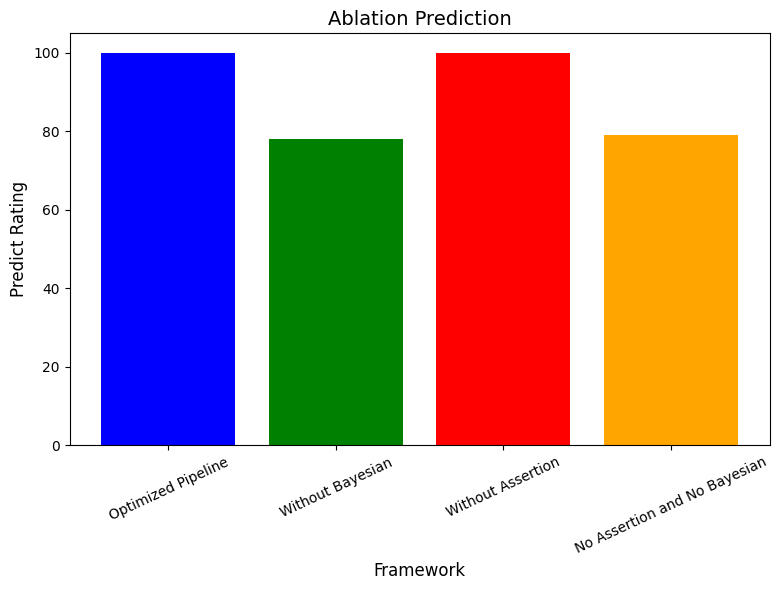

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from dspy.teleprompt import BayesianSignatureOptimizer
from dspy.evaluate.evaluate import Evaluate


def should_be_correct(sen, set):
  check=dspy.ChainOfThought("sentence -> sentiment", n = 5)
  result=check(sentence=f"Is this {set}; a correct sentiment for {sen}. Return 0 for False and 1 for True.")
  if result.sentiment==0:
    return False
  else:
    return True

class Emotion(dspy.Signature):
    """Classify emotion among sadness, joy, love, anger, fear, surprise."""

    sentence = dspy.InputField(desc = "Input sentence")
    sentiment = dspy.OutputField(desc = "Predicted Emotion in word")


class EmotionPipelineAssertions(dspy.Module):
    def __init__(self, assert_on=True):
        super().__init__()
        self.assert_on = assert_on
        self.Emotion_predicted = dspy.ChainOfThought(Emotion)

    def forward(self, sentence, **kwargs):
        predicted_Sentiment = self.Emotion_predicted(sentence=sentence)

        if self.assert_on:
            dspy.Suggest(
                should_be_correct(sentence, predicted_Sentiment),
                "Emotion is correct.",
                target_module=Emotion
            )

        return predicted_Sentiment


class Assess(dspy.Signature):
    """Assess the quality of the solution along the specified dimension."""

    assessed_text = dspy.InputField()
    assessment_sentence = dspy.InputField()
    assessment_sentiment = dspy.OutputField(desc="Only True or False")


def metric(gold, pred, trace=None):
    sentence, sentiment, emos = gold.sentence, gold.sentiment, pred.sentiment

    correctness = f"The given emos {emos} will be effective for this sentence {sentence}. The gold sentiment is {sentiment}"
    informative = f"For this sentence {sentence}, the given {emos} is informative. The gold sentiment is {sentiment}"

    correct = dspy.ChainOfThought(Assess)(assessed_text=sentence, assessment_sentence=correctness)
    informative = dspy.ChainOfThought(Assess)(assessed_text=sentence, assessment_sentence=informative)

    correctness_score = correct.assessment_sentiment
    info_score = informative.assessment_sentiment

    # Introduce variability by incorporating randomness
    import random
    # Randomly select which aspect of the metric to prioritize
    prioritize_correctness = random.choice([True, False])
    prioritize_informativeness = not prioritize_correctness

    # Penalize the score if both correctness and informativeness are not satisfied
    score = 0.5 if correctness_score == "True" else 0
    score += 0.5 if info_score == "True" else 0

    # Introduce additional complexity by considering the diversity of emotions predicted
    # and their coherence with the gold sentiment
    if prioritize_correctness and correctness_score != "True":
        # Penalize if the predicted emotions do not match the gold sentiment
        if emos != sentiment:
            score -= 0.1
    elif prioritize_informativeness and info_score != "True":
        # Penalize if the predicted emotions are not informative
        score -= 0.1

    return max(0, score)



# Define your devset and kwargs here
# Replace placeholders with your actual development dataset and any additional keyword arguments you need for evaluation

kwargs = dict(display_progress=True, display_table=5)

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate( devset = devset, num_threads=1, display_progress=True, display_table=5)

# Define function to evaluate pipeline
def evaluate_pipeline(assertion=True, bayesian=True):
    Emotion_predicted = EmotionPipelineAssertions()

    # Compile the pipeline with specified configurations
    if assertion and bayesian:
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(Emotion_predicted, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Optimized Pipeline"
    elif assertion and not bayesian:
        compiled_pipeline = Emotion_predicted
        config_label = "Without Bayesian"
    elif not assertion and bayesian:
        without_assertion=EmotionPipelineAssertions(assert_on=False)
        compiled_pipeline = BayesianSignatureOptimizer(metric=metric, n=5, init_temperature=1.0).compile(without_assertion, devset=devset, optuna_trials_num=5, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
        config_label = "Without Assertion"
    else:
        without_assertion_and_bayesian=EmotionPipelineAssertions(assert_on=False)
        compiled_pipeline = without_assertion_and_bayesian
        config_label = "No Assertion and No Bayesian"

    # Evaluate the compiled pipeline
    eval_score = evaluate_on_hotpotqa(compiled_pipeline, metric=metric)
    return eval_score, config_label


# Run the evaluation for each configuration

scores = []
config_labels = []

for assertion in [True, False]:
    for bayesian in [True, False]:
        eval_score, config_label = evaluate_pipeline(assertion=assertion, bayesian=bayesian)
        scores.append(eval_score)
        config_labels.append(config_label)



# Plotting the results
plt.figure(figsize=(8, 6))  # Adjust figure size
bar_colors = ['blue', 'green', 'red', 'orange']

x = np.arange(len(config_labels))
plt.bar(x, scores, color= bar_colors)
plt.xlabel('Framework',  fontsize=12)
plt.ylabel('Predict Rating',  fontsize=12)
plt.title('Ablation Prediction', fontsize=14)
plt.xticks(x, config_labels, rotation=25,  fontsize=10)

plt.tight_layout()
plt.show()
